In [3]:
import os
import datetime
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
def cal_ano(data_3d):
    # Remove the annual cycle
    data_df = pd.DataFrame(data_3d.mean(dim=('latitude', 'longitude')).values)
 
    Averaged = np.roll(np.array(data_df.rolling(window=21).mean()), -10, axis=0)
    Averaged[:10,:]  = Averaged[11,:][None,:]
    Averaged[-10:,:] = Averaged[-11,:][None,:]

    DailyVars = data_3d - Averaged[:,None] 

    # anomaly
    data_ano = DailyVars-DailyVars.mean(dim=('latitude', 'longitude'))

    return data_ano

def cal_ano_norm(data_3d):
    # Remove the annual cycle
    data_df = pd.DataFrame(data_3d.mean(dim=('latitude', 'longitude')).values)
 
    Averaged = np.roll(np.array(data_df.rolling(window=21).mean()), -10, axis=0)
    Averaged[:10,:]  = Averaged[11,:][None,:]
    Averaged[-10:,:] = Averaged[-11,:][None,:]

    DailyVars = data_3d - Averaged[:,None] 

    # Normalize the data
    data_ano = (DailyVars-DailyVars.mean(dim=('latitude', 'longitude')))/DailyVars.std(dim=('latitude', 'longitude'))  
    return data_ano

def cal_wt_comp(data_3d, n_wt, year_s, year_e, dir_wt, flnm_o):
    n_lat = data_3d.shape[1]
    n_lon = data_3d.shape[2]
    
    data_wt = np.zeros((n_wt, n_lat, n_lon))
    count_1d = np.zeros((n_wt)) 
    
    if os.path.isfile(flnm_o):
        print(flnm_o, 'exist')
    else: 
        for year in range(year_s, year_e + 1):
            # read WT file
            flnm_wt = dir_wt + 'CONUS-WTs_' + str(year) + '.cla'
            wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
            print(flnm_wt)
            StartDay = datetime.datetime(year, 1, 1)
            EndDay   = datetime.datetime(year, 12, 31)
            TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                
            i_s = year*10000 + 101
            i_e = year*10000 + 1231
            # do label based indexing loc
            data_0 = data_3d.loc[i_s:i_e]
            
            for nw in wts.wt.unique(): 
                wts_g = wts.groupby(['wt'])
                g_ind = wts_g.get_group(nw).index
                yyyymmdd = wts.year[g_ind]*10000 + wts.month[g_ind]*100 + wts.day[g_ind]                            
                yyyymmdd_wt = pd.to_datetime((yyyymmdd.values), format='%Y%m%d')
                
                # pick WT date
                iTime_2 = np.isin(TimeDD, yyyymmdd_wt)
                
                data_np = data_0[iTime_2].values                           
                data_wt[nw-1] = data_wt[nw-1] + data_np.sum(axis=0) 
                count_1d[nw-1] = count_1d[nw-1] + data_np.shape[0]
                
        for nw in range(n_wt):                     
            data_wt[nw] = data_wt[nw]/count_1d[nw]
            
        data_xr = xr.DataArray(data_wt, 
                                coords={'wt':range(1, n_wt + 1),
                                        'latitude': data_3d.latitude, 
                                        'longitude': data_3d.longitude},
                                dims=['wt', 'latitude', 'longitude'],
                                attrs = {'script':'Ming Ge: qmsl_wt_ERAI.ipynb'})
                     
        data_xr = data_xr.rename('data') 
        print(flnm_o)
        data_xr.to_netcdf(path = flnm_o) 

In [5]:
dir_uv = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/UV700/'
dir_q  = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/Q700/'
dir_msl = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/MSL/'

year_s = 1979
year_e = 2014
n_year = year_e - year_s + 1

- read Q700

In [6]:
%%time
is_first = True
 
for year in range(year_s, year_e+1):
    flnm_q = dir_q + 'q700_' + str(year) + '_12Z.nc'

    with  xr.open_dataset(flnm_q) as ds:
        q700 = ds.q700_us
        
        # concatenate annual data files 
        if is_first:
            q700_3d = q700.copy()
            is_first = False
        else:
            q700_3d = xr.concat([q700_3d, q700], dim="time") 

# anomaly the data
q700_ano = cal_ano(q700_3d)

# Normalize the data
q700_ano_norm = cal_ano_norm(q700_3d)

CPU times: user 5.72 s, sys: 3.7 s, total: 9.42 s
Wall time: 12.5 s


- read MSL

In [7]:
%%time
is_first = True
 
for year in range(year_s, year_e+1):
    flnm_msl = dir_msl + 'msl_' + str(year) + '_12Z.nc'
    
    with  xr.open_dataset(flnm_msl) as ds:
        msl = ds.msl_us
        
        # concatenate annual data files 
        if is_first:
            msl_3d = msl.copy()
            is_first = False
        else:
            msl_3d = xr.concat([msl_3d, msl], dim="time") 

# Anomaly the data
msl_ano = cal_ano(msl_3d)

# Normalize the data
msl_ano_norm = cal_ano_norm(msl_3d)

CPU times: user 4.65 s, sys: 3.59 s, total: 8.24 s
Wall time: 11.2 s


-  Read U700, V700

In [8]:
%%time
is_first = True
 
for year in range(year_s, year_e+1):
    flnm_u = dir_uv + 'u700_' + str(year) + '_12Z.nc'
    flnm_v = dir_uv + 'v700_' + str(year) + '_12Z.nc'
    #print(flnm_q, 'exist')
    with  xr.open_dataset(flnm_u) as ds:
        u700 = ds.u700_us
    with  xr.open_dataset(flnm_v) as ds:
        v700 = ds.v700_us
        
        # concatenate annual data files 
        if is_first:
            u700_3d = u700.copy()
            v700_3d = v700.copy()
            is_first = False
        else:
            u700_3d = xr.concat([u700_3d, u700], dim="time") 
            v700_3d = xr.concat([v700_3d, v700], dim="time") 

# Anomaly the data
u700_ano = cal_ano(u700_3d)
v700_ano = cal_ano(v700_3d)

# Normalize the data
u700_ano_norm = cal_ano_norm(u700_3d)
v700_ano_norm = cal_ano_norm(v700_3d)

CPU times: user 9.27 s, sys: 7.44 s, total: 16.7 s
Wall time: 22.3 s


#### associate with Weather type

In [9]:
dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/WT/'
n_wt = 12

var_1d = ['q700', 'msl', 'u700', 'v700']

n_lat = q700_3d.shape[1]
n_lon = q700_3d.shape[2]

for var_s in var_1d:
    print(var_s)
    data_wt = np.zeros((n_wt, n_lat, n_lon))
    count_1d = np.zeros((n_wt)) 
    
    if  var_s == 'q700':
        data_3d = q700_3d
        data_ano_3d = q700_ano
        data_ano_norm_3d = q700_ano_norm
        dir_o = dir_q
    elif  var_s == 'u700':
        data_3d = u700_3d
        data_ano_3d = u700_ano
        data_ano_norm_3d = u700_ano_norm
        dir_o = dir_uv
    elif  var_s == 'v700':
        data_3d = v700_3d
        data_ano_3d = v700_ano
        data_ano_norm_3d = v700_ano_norm
        dir_o = dir_uv
    elif  var_s == 'msl':
        data_3d = msl_3d
        data_ano_3d = msl_ano
        data_ano_norm_3d = msl_ano_norm
        dir_o = dir_msl
        
    flnm_o = dir_o + var_s + '_wt.nc'
    flnm_ano_o = dir_o + var_s + '_ano_wt.nc'
    flnm_ano_norm_o = dir_o + var_s + '_ano_norm_wt.nc'
    
    cal_wt_comp(data_3d, n_wt, year_s, year_e, dir_wt, flnm_o) 
    cal_wt_comp(data_ano_3d, n_wt, year_s, year_e, dir_wt, flnm_ano_o)
    cal_wt_comp(data_ano_norm_3d, n_wt, year_s, year_e, dir_wt, flnm_ano_norm_o)

q700
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/Q700/q700_wt.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/Q700/q700_ano_wt.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/Q700/q700_ano_norm_wt.nc exist
msl
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/MSL/msl_wt.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/MSL/msl_ano_wt.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/MSL/msl_ano_norm_wt.nc exist
u700
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/UV700/u700_wt.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/UV700/u700_ano_wt.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/UV700/u700_ano_norm_wt.nc exist
v700
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/UV700/v700_wt.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/UV700/v700_ano_wt.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERAI/UV700/v700_ano_norm_wt.nc exist


#### Plot anomaly MSL overlay anomaly q700 (contour) and 700 hPa wind vectory 

/glade/derecho/scratch/mingge/tmp/ipykernel_2401/4131780118.py:71: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = cntr.collections[i].get_paths()
/glade/derecho/scratch/mingge/tmp/ipykernel_2401/4131780118.py:73: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  color = cntr.collections[i].get_edgecolor()[0]


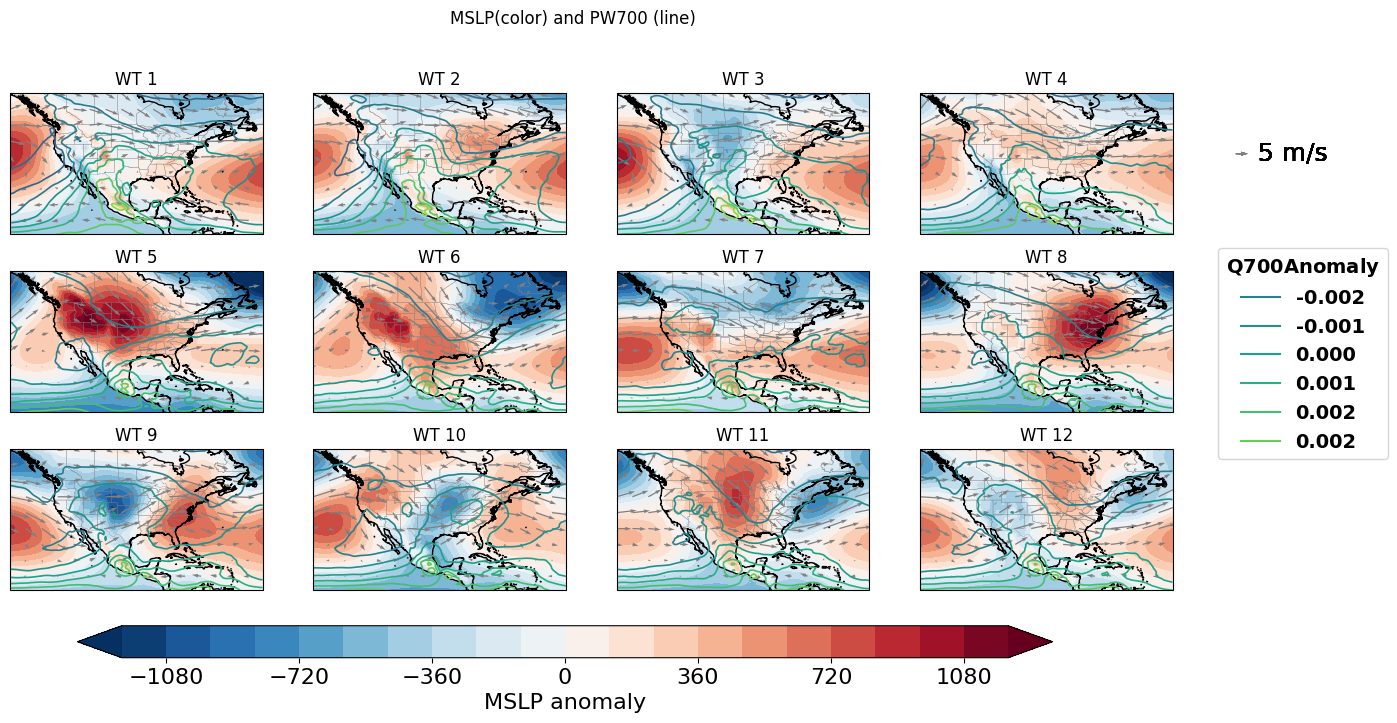

In [14]:
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(3, 4, figsize=(15, 8), subplot_kw={'projection': proj})

levels = np.linspace(-1200, 1200, 21)
levels_q = np.linspace(-0.006, 0.006, 7)

lat_1d = v700_3d.latitude
lon_1d = v700_3d.longitude

flnm_q = dir_q + 'q700_ano_wt.nc'
with  xr.open_dataset(flnm_q) as ds:
    q700 = ds.data

flnm_msl = dir_msl + 'msl_ano_wt.nc'
with  xr.open_dataset(flnm_msl) as ds:
    msl = ds.data
 
flnm_u = dir_uv + 'u700_wt.nc'
with  xr.open_dataset(flnm_u) as ds:
    u700 = ds.data 
    
flnm_v = dir_uv + 'v700_wt.nc'
with  xr.open_dataset(flnm_v) as ds:
    v700 = ds.data

# rename 
values = [5,3,12,8,4,10,11,9,2,6,7,1]

msl_new = msl.copy()
q700_new = q700.copy()
u700_new = u700.copy()
v700_new = v700.copy()
for nw in range(12):
    msl_new[values[nw]-1] = msl[nw]
    q700_new[values[nw]-1] = q700[nw]
    u700_new[values[nw]-1] = u700[nw]
    v700_new[values[nw]-1] = v700[nw]

ct = 0
for nr in range(0,3):
    for nc in range(0,4):
        msl_img = axs[nr,nc].contourf(lon_1d, lat_1d, msl_new[ct], levels=levels, cmap='RdBu_r', extend='both')
        # pw =axs[nr,nc].contour(rgrLonWT, rgrLatWT, rgrCentroids[ct,2],colors='k')
        cntr = axs[nr,nc].contour(lon_1d, lat_1d, q700_new[ct], cmap = 'viridis', linewidths=1.2, levels=7, vmin=-0.006, vmax=0.006)

        # add legend of arrow created with quiver
        Q=axs[nr,nc].quiver(lon_1d[::8], lat_1d[::8], u700_new[ct,::8,::8], v700_new[ct,::8,::8], color = 'grey' )
        #axs[nr,nc].quiverkey(Q, 0.95, 0.8, 5, r'$5 \frac{m}{s}$', labelpos='E',coordinates='figure')
        axs[nr,nc].quiverkey(Q, 0.95, 0.8, 5, '5 m/s', 
                             fontproperties={'size':18},
                            labelpos='E', coordinates='figure')
        
        # Add coastlines
        axs[nr, nc].coastlines()
        axs[nr, nc].add_feature(cfeature.STATES, zorder=1, linewidth=.2, edgecolor='grey')
        axs[nr,nc].title.set_text("WT " + str(ct+1))
        ct +=1

# Set a Single Main Title for All the Subplots
fig.suptitle('MSLP(color) and PW700 (line)', fontsize=12)

# rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
 
fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.17, 0.17, 0.65, 0.04])
clb = fig.colorbar(msl_img, cax=cbar_ax, orientation="horizontal");
clb.set_label('MSLP anomaly', size=16) # , weight='bold'
clb.ax.tick_params(labelsize=16)

legend_properties = {'weight':'bold', "size": 14}
# Create proxy artists for the legend
proxy_lines = []
for i, level in enumerate(cntr.levels):
        paths = cntr.collections[i].get_paths()
        if paths:  # Check if there are any paths for this level
            color = cntr.collections[i].get_edgecolor()[0]
            proxy_lines.append(plt.Line2D([0], [0], color=color))

l = [f'{a:.3f}' for a in cntr.levels]
fig.legend(proxy_lines,l, loc='center right', title='$\\bf{Q700 Anomaly}$', 
           title_fontsize='14', prop=legend_properties,
          bbox_to_anchor=(1.05, 0.55))

# for a paper, a thesis, or a poster, 600dpi should be good enough.
dir_plot = '/glade/campaign/mmm/c3we/mingge/COEXIST/PLOT/PAPER/'
# 300 dpi (the minimum requirement for many journals):
plt.savefig(dir_plot + 'qmsl_ano_wt_ERAI.pdf', dpi=600, bbox_inches='tight');

#### Plot normalized anomaly MSL overlay normalized anomaly q700 (contour) and 700 hPa wind vectory

/glade/derecho/scratch/mingge/tmp/ipykernel_2401/3578328960.py:66: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = cntr.collections[i].get_paths()
/glade/derecho/scratch/mingge/tmp/ipykernel_2401/3578328960.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  color = cntr.collections[i].get_edgecolor()[0]


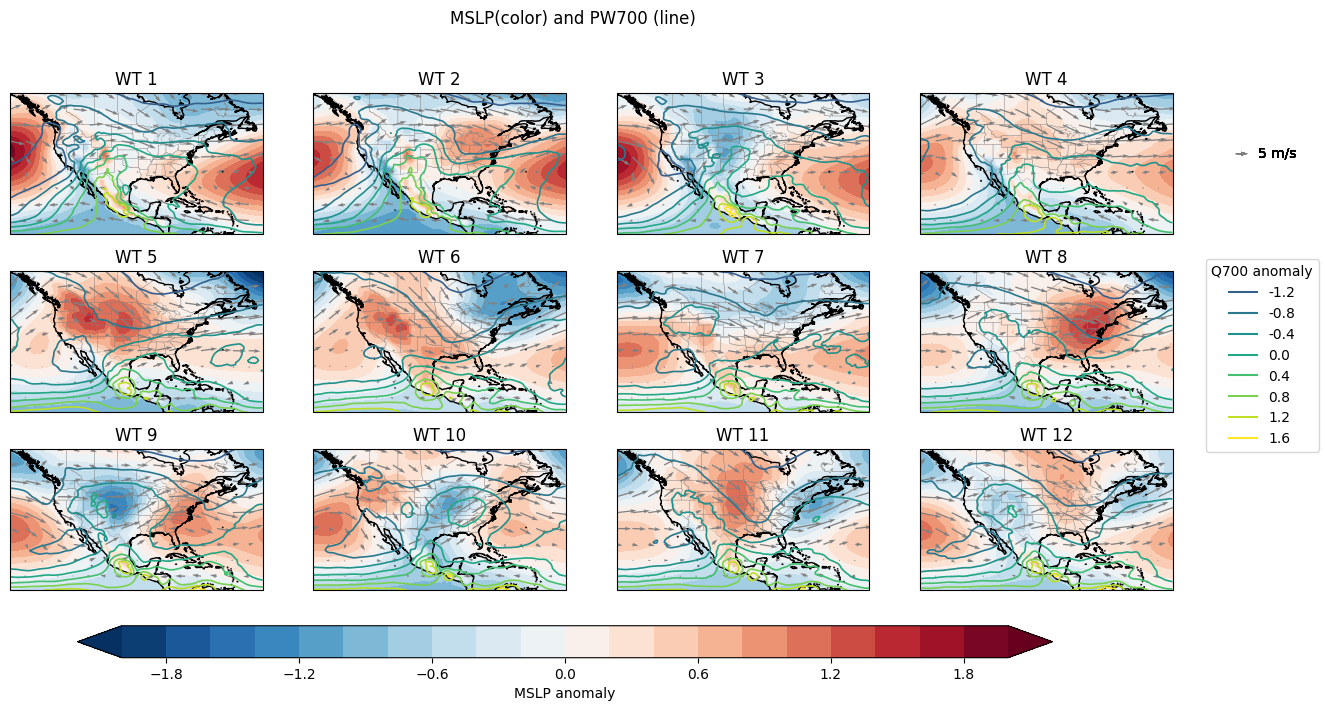

In [19]:
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(3, 4, figsize=(15, 8), subplot_kw={'projection': proj})

ct = 0
#levels = np.linspace(-1.6, 1.6, 33)
levels = np.linspace(-2, 2, 21)
lat_1d = v700_3d.latitude
lon_1d = v700_3d.longitude

flnm_q = dir_q + 'q700_ano_norm_wt.nc'
with  xr.open_dataset(flnm_q) as ds:
    q700 = ds.data

flnm_msl = dir_msl + 'msl_ano_norm_wt.nc'
with  xr.open_dataset(flnm_msl) as ds:
    msl = ds.data
 
flnm_u = dir_uv + 'u700_wt.nc'
with  xr.open_dataset(flnm_u) as ds:
    u700 = ds.data 
    
flnm_v = dir_uv + 'v700_wt.nc'
with  xr.open_dataset(flnm_v) as ds:
    v700 = ds.data 

# relabel 
values = [5,3,12,8,4,10,11,9,2,6,7,1]
for nw in range(12):
    msl_new[values[nw]-1] = msl[nw]
    q700_new[values[nw]-1] = q700[nw]
    u700_new[values[nw]-1] = u700[nw]
    v700_new[values[nw]-1] = v700[nw]

ct = 0
for nr in range(0,3):
    for nc in range(0,4):
        msl_img = axs[nr,nc].contourf(lon_1d, lat_1d, msl_new[ct], levels=levels, cmap='RdBu_r', extend='both')
        cntr = axs[nr,nc].contour(lon_1d, lat_1d, q700_new[ct], cmap = 'viridis', linewidths=1.2, levels=7, vmin=-2, vmax=2)

        
        # add legend of arrow created with quiver
        Q=axs[nr,nc].quiver(lon_1d[::8], lat_1d[::8], u700_new[ct,::8,::8], v700_new[ct ,::8,::8], color = 'grey' )
        #axs[nr,nc].quiverkey(Q, 0.95, 0.8, 5, r'$5 \frac{m}{s}$', labelpos='E',coordinates='figure')
        axs[nr,nc].quiverkey(Q, 0.95, 0.8, 5, '5 m/s', labelpos='E',coordinates='figure')
        
        # Add coastlines
        axs[nr, nc].coastlines()
        axs[nr, nc].add_feature(cfeature.STATES, zorder=1, linewidth=.2, edgecolor='grey')
         
        axs[nr,nc].title.set_text("WT " + str(ct+1))
        ct += 1

# Set a Single Main Title for All the Subplots
fig.suptitle('MSLP(color) and PW700 (line)', fontsize=12)

# rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
 
fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.17, 0.17, 0.65, 0.04])
clb = fig.colorbar(msl_img, cax=cbar_ax, orientation="horizontal");
clb.set_label('MSLP anomaly')

#h = cntr.collections
proxy_lines = []
for i, level in enumerate(cntr.levels):
        paths = cntr.collections[i].get_paths()
        if paths:  # Check if there are any paths for this level
            color = cntr.collections[i].get_edgecolor()[0]
            proxy_lines.append(plt.Line2D([0], [0], color=color))
l = [f'{a:.1f}' for a in cntr.levels]
fig.legend(proxy_lines,l, loc='center right', title='Q700 anomaly')

#  for a paper, a thesis, or a poster, 600dpi should be good enough.
dir_plot = '/glade/campaign/mmm/c3we/mingge/COEXIST/PLOT/PAPER/'
# 300 dpi (the minimum requirement for many journals):
plt.savefig(dir_plot + 'qmsl_wt_ERAI.pdf', dpi=600, bbox_inches='tight')